# MTL Hardware description

## MTL Composed of:
#####    - 2 Atoms quad
#####    - 2 Big cores
#####    - 1 GT
#####    - 1 Display
#####    - LLC & DDR memories
#####    - They are connected to Bus (1 port for quad)

In [1]:
# Platform modules
from asap.system_platform import Platform
from asap.hw import Clock, GlobalClock
from asap.states import ActiveState, PowerState, Condition, Expression, HierarchyState, Constraint, Force
from asap.ips import IP, Driver, ExecutingUnit, Port
from asap.buses import Bus
from asap.memories import Memory
from asap.strings import PENALTY, StateDesc

### Creating platform step by step - adding required IP states accordingly

#### System clocks

In [2]:
PENALTY_VAL = 1.13333

# Platform
sys_platform = Platform("MTL")

# Clocks
clk = GlobalClock("global_clk", 0.001).instance
a_clk = Clock("a_clk", 0.001)    # 1 ns
b_clk = Clock("b_clk", 0.001)    # 1 ns
g_clk = Clock("g_clk", 0.001)    # 1 ns
d_clk = Clock("d_clk", 0.001)    # 1 ns
adm_clk = Clock("adm_clk", 0.001)    # 1 ns
ddr_clk = Clock("ddr_clk", 0.001)    # 1 ns
sys_platform.add_clocks([clk, a_clk, b_clk, g_clk, d_clk, adm_clk, ddr_clk])
system_light_sleep_cond = list()


#### Atoms

In [3]:
atoms = dict()
for atom_name in ["AtomQuad{}".format(i) for i in range(2)]:
    atom_sleep_conditions = list()
    p = Port(atom_name + "_p")
    dr = Driver("driver", a_clk)
    dr.active_state.system_dependency = 'PC0'
    ex_units = list()
    for ex in ["ex_u{}".format(j) for j in range(4)]:
        ex_units.append(ExecutingUnit(ex, a_clk))
    

    atom = IP(atom_name, a_clk, ex_units, [dr], [p])
    for ex in ex_units:
        ex.active_state.system_dependency = 'PC0'
        atom_sleep_conditions.append(Condition(ex, StateDesc.LESS_EQUAL, 'C6'))
        # Constraint
        atom_exu_active_exp = Expression('atom_EXU_Active_{}_{}'.format(atom_name, ex.name), [Condition(ex, StateDesc.EQUAL, 'ACTIVE')])
        dr.add_constraint(Constraint(dr.power_states[0].name, atom_exu_active_exp))
        # Forces
        dr.add_force(Force(dr.active_state.name, 1, atom_exu_active_exp))
        
    atom_sleep_conditions.append(Condition(dr, StateDesc.LESS_EQUAL, 'C6'))
    atom_sleep_exp = Expression('AtomSleep{}'.format(atom_name), atom_sleep_conditions)
    atom.ip_states = [
        HierarchyState('C0', idle_time=5),
        HierarchyState('C6', idle_time=5, expression=atom_sleep_exp),
    ]
    system_light_sleep_cond += atom_sleep_conditions
    
    atom.connect_driver(dr, p)
    atom.attach_attribute(PENALTY, PENALTY_VAL)
    sys_platform.add_ip(atom)
    atoms[atom_name] = (atom, p)

#### Big cores

In [4]:
# Big cores
bCores = dict()
for i in range(2):
    bCore_sleep_conditions = list()
    bCoreP = Port("BigCore{}_p".format(i))
    dr = Driver("driver", b_clk)
    dr.active_state.system_dependency = 'PC0'
    ex_u = ExecutingUnit("ex_u", b_clk, 1)
    ex_u.active_state.system_dependency = 'PC0'
    bCore = IP("BigCore{}".format(i), b_clk, [ex_u], [dr], [bCoreP])
    bCore.connect_driver(dr, bCoreP)
    bCore.attach_attribute(PENALTY, 1)
    
    bCore_sleep_conditions.append(Condition(ex_u, StateDesc.LESS_EQUAL, 'C6'))
    bCore_sleep_conditions.append(Condition(dr, StateDesc.LESS_EQUAL, 'C6'))
    bCore_sleep_exp = Expression('bCoresSleep{}'.format(i), bCore_sleep_conditions)
    system_light_sleep_cond += bCore_sleep_conditions
    bCore.ip_states =  [
        HierarchyState('C0', idle_time=5),
        HierarchyState('C6', idle_time=5, expression=bCore_sleep_exp),
    ]
    sys_platform.add_ip(bCore)
    bCores[bCore.name] = (bCore, bCoreP)
    
    # Constraints
    bigcore_exu_active_exp = Expression('BIGCORE_EXU_Active{}'.format(i), [Condition(ex_u, StateDesc.EQUAL, 'ACTIVE')])
    dr.add_constraint(Constraint(dr.power_states[0].name, bigcore_exu_active_exp))
    # Force
    dr.add_force(Force(dr.active_state.name, 1, bigcore_exu_active_exp))


#### GT

In [5]:
# GT 
gt_p = Port('gt_p')
gt_dr = Driver('dr', g_clk)
gt_dr.active_state.system_dependency = 'PC0'
gt_ex = ExecutingUnit('ex_u', g_clk)
gt_ex.active_state.system_dependency = 'PC0'
gt = IP("GT", g_clk, [gt_ex], [gt_dr], [gt_p])
gt.connect_driver(gt_dr, gt_p)
sys_platform.add_ip(gt)


# GT states
gt_sleep_conditions = list()
gt_sleep_conditions.append(Condition(gt_ex, StateDesc.LESS_EQUAL, 'C6'))
gt_sleep_conditions.append(Condition(gt_dr, StateDesc.LESS_EQUAL, 'C6'))
gt_sleep_exp = Expression('GTSleep', gt_sleep_conditions)
system_light_sleep_cond += gt_sleep_conditions
gt.ip_states =  [
    HierarchyState('RC0', idle_time=1),
    HierarchyState('RC6', idle_time=1, expression=gt_sleep_exp),]

# Constraints
gt_exu_active_exp = Expression('GT_EXU_Active', [Condition(gt_ex, StateDesc.EQUAL, 'ACTIVE')])
gt_dr.add_constraint(Constraint(gt_dr.power_states[0].name, gt_exu_active_exp))

# Force
gt_dr.add_force(Force(gt_dr.active_state.name, 1, gt_exu_active_exp))

#### Display

In [6]:
# Display
display_p = Port('display_p')
display_ex = ExecutingUnit('ex_u', d_clk, )
display_ex.active_state.system_dependency = 'PC8'
display_dr = Driver('dr', d_clk)
display_ex.active_state.system_dependency = 'PC2R'

display = IP("Disp", d_clk, [display_ex], [display_dr], [display_p])
display.connect_driver(display_dr, display_p)
sys_platform.add_ip(display)

# Building the display sleep expression
# only supports StateDesc.LESS_EQUAL or StateDesc.EQUAL
# negate attrbiute in condition - if you want it to be a not condition set as True
display_dr_sleep_cond = Condition(display_dr, StateDesc.LESS_EQUAL, 'C6')
display_ex_sleep_cond = Condition(display_ex, StateDesc.LESS_EQUAL, 'C6')
display_sleep_exp = Expression('DisplaySleep', [display_dr_sleep_cond, display_ex_sleep_cond]) # The connection between the conditions is AND
display_exec_sleep_exp = Expression('DisplayExecSleep', [display_ex_sleep_cond])

# By not setting an expression for the hierarchy state it sets the expression as always true expression
display.ip_states = [
    HierarchyState('DC0', idle_time=1),
    HierarchyState('DC1', idle_time=1, expression=display_exec_sleep_exp),
    HierarchyState('DC2', idle_time=1, expression=display_exec_sleep_exp),
    HierarchyState('DC2.1', idle_time=1, expression=display_exec_sleep_exp),
    HierarchyState('DC2.2', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC3', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC4', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC5', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC6', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC7', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC8', idle_time=1, expression=display_sleep_exp)
]  

#### Fabrics, Memories and Connectivities

In [7]:
# IP Buses
quad0_cbo = Bus('quad0_cbo', clk, 64)
quad1_cbo = Bus('quad1_cbo', clk, 64)
big0_cbo = Bus('big0_cbo', clk, 64)
big1_cbo = Bus('big1_cbo', clk, 64)


# System buses
ccf = Bus('ccf', b_clk, 64)
cmf = Bus('cmf', b_clk, 64)
noc = Bus('noc', b_clk, 64)
mem = Bus('mem', b_clk, 64)


sys_platform.add_buses([quad0_cbo, quad1_cbo, big0_cbo, big1_cbo, ccf, cmf, noc, mem])


# Memories
llc = Memory('LLC', clk, 1024, bus_width=64)
ddr = Memory('DDR', ddr_clk, 1024, bus_width=64)
adm = Memory('ADM', adm_clk, 1024, bus_width=64)

sys_platform.add_memories([llc, ddr, adm])

sys_platform.connect_to_bus(atoms["AtomQuad0"][1], quad0_cbo)
sys_platform.connect_to_bus(atoms["AtomQuad1"][1], quad1_cbo)
sys_platform.connect_to_bus(bCores["BigCore0"][1], big0_cbo) 
sys_platform.connect_to_bus(bCores["BigCore1"][1], big1_cbo) 

sys_platform.connect_to_bus(big0_cbo, ccf) 
sys_platform.connect_to_bus(big1_cbo, ccf) 
sys_platform.connect_to_bus(quad0_cbo, ccf) 
sys_platform.connect_to_bus(quad1_cbo, ccf) 
sys_platform.connect_to_memory(ccf, llc) 
sys_platform.connect_to_memory(cmf, adm) 
sys_platform.connect_to_memory(mem, ddr) 
sys_platform.connect_to_bus(ccf, cmf)
sys_platform.connect_to_bus(gt_p, noc) 
sys_platform.connect_to_bus(display_p, noc) 
sys_platform.connect_to_bus(noc, cmf) 
sys_platform.connect_to_bus(cmf, mem) 
sys_platform.validate_platform()

Validating System platform: MTL...
System platform is valid!


In [8]:
system_light_sleep_exp = Expression('SystemLightSleep', system_light_sleep_cond)
system_light_no_display_sleep_exp = Expression('SystemLightNoDisplaySleep', system_light_sleep_cond + [display_dr_sleep_cond])
system_heavy_sleep_exp = Expression('SystemHeavySleep', system_light_sleep_cond + [display_dr_sleep_cond, display_ex_sleep_cond])

# The order of the list is the order of the transition between system states
sys_platform.system_states = [
    HierarchyState('PC0', idle_time=1),
    HierarchyState('PC2', idle_time=1, expression=system_light_sleep_exp),
    HierarchyState('PC2R', idle_time=5, expression=system_light_sleep_exp),
    HierarchyState('PC3', idle_time=5, expression=system_light_no_display_sleep_exp),
    HierarchyState('PC6', idle_time=5, expression=system_light_no_display_sleep_exp),
    HierarchyState('PC7', idle_time=5, expression=system_light_no_display_sleep_exp),
    HierarchyState('PC8', idle_time=5, expression=system_light_no_display_sleep_exp),
    HierarchyState('PC9', idle_time=5, expression=system_heavy_sleep_exp),
    HierarchyState('PC10', idle_time=5, expression=system_heavy_sleep_exp),
]  

# Exit system states transition
from asap.states import StateTransition
sys_platform.system_states_exit_transitions = [
    StateTransition('PC2', 'PC0', 20),
    StateTransition('PC2R', 'PC0', 35),
    StateTransition('PC3', 'PC0', 80),
    StateTransition('PC3', 'PC2R', 20),
    StateTransition('PC6', 'PC0', 90),
    StateTransition('PC6', 'PC2R', 30),
    StateTransition('PC7', 'PC0', 120),
    StateTransition('PC7', 'PC2R', 60),
    StateTransition('PC8', 'PC0', 200),
    StateTransition('PC8', 'PC2R', 80),
    StateTransition('PC9', 'PC0', 220),
    StateTransition('PC9', 'PC2R', 90),
    StateTransition('PC9', 'PC8', 10),
    StateTransition('PC10', 'PC0', 250),
    StateTransition('PC10', 'PC2R', 100),
    StateTransition('PC10', 'PC8', 20)
]

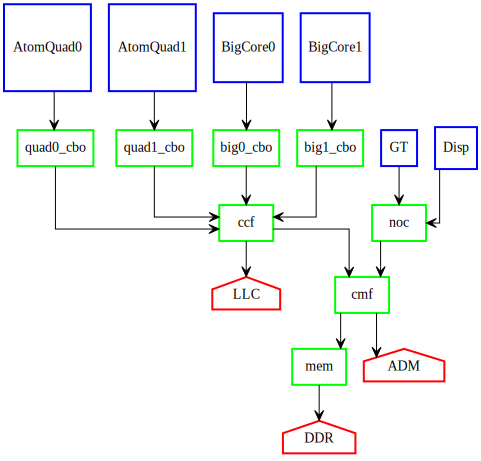

In [9]:
# Drawing platform
sys_platform

# Atom first system scheduler
##### Preferes to map task of map type "Core" to atoms first, if no atom is available then map to big cores
##### Tasks mapped to atom gets extra penalty

In [10]:
from asap.schedulers import SystemScheduler
from asap.mapping import MappingEntity
from asap.strings import SchedulingState

class AtomFirstScheduler(SystemScheduler):
    """
    Atom first scheduler:
        Prefers to map to Atoms first tasks w/ attribute MAP_TYPE == Core. Any task mapped to atom gets extra penalty.
        If all atoms are busy then map to CPU without any extra penalty.
    """
    def __init__(self, system_mgr, properties=None, platform_scheduler=None):
        super().__init__(system_mgr, properties, platform_scheduler)
        self._atoms = self._get_ips(['AtomQuad0', 'AtomQuad1'])
        self._bCores = self._get_ips(['BigCore0', 'BigCore1'])
        self._gt = self._get_ips(['GT'])[0]
        self._display = display

    def _get_ips(self, names):
        ips = list()
        for ip in self._system_mgr.sys_platform.ips:
            if ip.name in names:
                ips.append(ip)
        return ips

    def schedule_task(self, task, resource=None):
        """
        Schedule task according to task attribute MAP_TYPE.
        if MAP_TYPE is not defines on task then task will run unmapped
        """
        if resource is not None:
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, resource)])
        task_map_type = task.get_attribute('MAP_TYPE', None)
        if task_map_type is None:
            return self._platform_scheduler.schedule_task(task, list())
        elif task_map_type == 'GT':
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, self._gt)])
        elif task_map_type == 'Core':
            r, t = self._platform_scheduler.schedule_task(task, [MappingEntity(task, a) for a in self._atoms])
            if r is not None or t != SchedulingState.NAN:
                return r, t
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, b) for b in self._bCores])
        elif task_map_type == 'Display':
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, self._display)])
        else:
            return self._platform_scheduler.schedule_task(task, list())

    def on_task_finish(self, task):
        self._platform_scheduler.on_task_finish(task)


## Loading worklaod from PNML & adding display part to it

In [11]:
from asap.utils import create_rpw_task, from_pnml_file
from asap.workload import Task, Workload, TYPES
from asap.mapping import Mapping

# pnml_path = '/nfs/iil/proj/dt/vppnp01/work/saeedess/my_ws/SpeedSim/tg/vpb_9.178_9.3118.extended.pnml'
# pnml_path = '/nfs/iil/proj/dt/vppnp01/work/saeedess/my_ws/SpeedSim/tg/VPB_tr_10.0_15.0_strict_tr_10.0_15.0_cluster_0.extended.pnml'
# pnml_path = '/nfs/iil/proj/dt/vppnp01/work/saeedess/my_ws/SpeedSim/tg/VPB_4K_tr_5.0_10.0_strict_tr_5.0_10.0_cluster_0.extended.pnml'
pnml_path = '/nfs/iil/proj/dt/vppnp01/work/saeedess/my_ws/SpeedSim/tg/chrome_custom_browsing_tr_306.209_306.309_strict_tr_306.209_306.309_cluster_0.extended.pnml'
# pnml_path = '/nfs/iil/proj/dt/vppnp01/work/saeedess/my_ws/SpeedSim/tg/AzR_tr_95.0_100.0_strict_tr_95.0_100.0_cluster_0.extended.pnml'
# pnml_path = '/nfs/iil/proj/dt/vppnp01/work/saeedess/my_ws/SpeedSim/tg/chrome_custom_browsing_0_286.161_286.261.extended.pnml'

# Capability of adding dynamic attributes and mapping during load pnml
# MEMORY ALLOCATION CONTROL - Per split, DDR and ADM
hw_resources = {'CPU': {'resource': atoms['AtomQuad0'][0], 'attributes': {'MAP_TYPE': 'Core', 'MEMORY_TARGET': 'DDR'}}, 
                'GT_GFX': {'resource': gt, 'attributes': {'MAP_TYPE': 'GT', 
                                                          'MEMORY_TARGETS_DISTRIBUTION': [
                                                              {'MEMORY_TARGETS': {'DDR': 40, 'ADM': 60}, 'DATA_PORTION': 30},
                                                              {'MEMORY_TARGETS': {'DDR': 20, 'ADM': 80}, 'DATA_PORTION': 30},
                                                              {'MEMORY_TARGETS': {'DDR': 10, 'ADM': 90}, 'DATA_PORTION': 5}]}}}

# MEMORY ALLOCATION CONTROL - Per split, DDR ONLY
# hw_resources = {'CPU': {'resource': atoms['AtomQuad0'][0], 'attributes': {'MAP_TYPE': 'Core', 'MEMORY_TARGET': 'DDR'}}, 
#                 'GT_GFX': {'resource': gt, 'attributes': {'MAP_TYPE': 'GT', 
#                                                           'MEMORY_TARGETS_DISTRIBUTION': [
#                                                               {'MEMORY_TARGETS': {'DDR': 100}, 'DATA_PORTION': 30},
#                                                               {'MEMORY_TARGETS': {'DDR': 100}, 'DATA_PORTION': 30},
#                                                               {'MEMORY_TARGETS': {'DDR': 100}, 'DATA_PORTION': 5}]}}}

# ONE MEMORY TARGET OF DDR FOR GT ( PLEASE BE CAREFELL, ABOVE has MEMORY_TARGETS and here MEMORY_TARGET!!!)
# hw_resources = {'CPU': {'resource': atoms['AtomQuad0'][0], 'attributes': {'MAP_TYPE': 'Core', 'MEMORY_TARGET': 'DDR'}}, 
#                 'GT_GFX': {'resource': gt, 'attributes': {'MAP_TYPE': 'GT', 'MEMORY_TARGET': 'DDR'}} } 

# CHANGE read_proc_buf_size and proc_write_buf_size to control buffer size between read, process and write.
# Creating Read-Process-Write for each pnml task on GT and CPU. Control SPLIT by setting proper value
tasks_att = [{'hw_resource': {'values': ['GT_GFX'], 
                              'function_data': {'function': create_rpw_task, 
                                                'metadata': {'read_proc_buf_size': 5, 'proc_write_buf_size': 5, 'split': 10}}}},
            {'hw_resource': {'values': ['CPU'], 
                              'function_data': {'function': create_rpw_task, 
                                                'metadata': {'read_proc_buf_size': 5, 'proc_write_buf_size': 5, 'split': 10}}}}]
workload, mapping = from_pnml_file(pnml_path, 'workload', hw_resources=hw_resources, tasks_att=tasks_att)

# Display part
# Display parameters
D_FPS = 60
SECOND = 1000000
PIXEL_BITS = 32
BUFF_SIZE = 512000
VSYNC_TIME = 100 / d_clk.period # 100 us
WAIT_TO_CYCLES = 500 / d_clk.period  # 500 us
NUMBER_OF_FILL_DRAIN_CYCLES = 10
FRAME_TIME = SECOND / D_FPS # one frame amount of time in us
FILL_DATA = (PIXEL_BITS * 1080 * 1920 / 8) / NUMBER_OF_FILL_DRAIN_CYCLES # data bytes for the fill task
CYCLE_TIME = (FRAME_TIME - WAIT_TO_CYCLES * d_clk.period) / NUMBER_OF_FILL_DRAIN_CYCLES

# Display TG
start = Task('d_start',TYPES.START, wait_delay=FRAME_TIME, iterations=1000000)
wait_to_cycles = Task('wait_to_cycles', TYPES.PROC, processing_cycles=WAIT_TO_CYCLES)
fill_task = Task('fill', type=TYPES.READ, read_bytes=FILL_DATA)
fill_task.attach_attribute('MAP_TYPE', 'Display')
fill_task.attach_attribute('DISPLAY_TYPE', 'fill')
fill_task.attach_attribute('MEMORY_TARGETS', {'DDR': 100})
drain_task = Task('drain', type=TYPES.PROC, processing_cycles=1000)
drain_task.attach_attribute('DISPLAY_TYPE', 'drain')
drain_task.attach_attribute('CYCLE_TIME', CYCLE_TIME)
vsync = Task('vsync', type=TYPES.PROC, processing_cycles=VSYNC_TIME)
vsync.attach_attribute('MAP_TYPE', 'Display')
end = Task('d_end',TYPES.END)
workload.add_tasks([start, fill_task, drain_task, vsync, wait_to_cycles, end])
workload.connect_tasks('start_to_vsync', start, vsync)
workload.connect_tasks('vsync_to_dummy_wait', vsync, wait_to_cycles)
workload.connect_tasks('dummy_to_fill', wait_to_cycles, fill_task, put_samples=NUMBER_OF_FILL_DRAIN_CYCLES, buf_size=NUMBER_OF_FILL_DRAIN_CYCLES)
workload.connect_tasks('fill_to_drain', fill_task, drain_task)
workload.connect_tasks('drain_to_fill_feedback', drain_task, fill_task, init=1)
workload.connect_tasks('drain_to_end', drain_task, end)
mapping.map_task(fill_task, display)
mapping.map_task(vsync, display)


-W- Unknown attribute type for runtime: None
-W- Unknown attribute type for cycles: None
-W- Unknown attribute type for frequency: None
-W- Unknown attribute type for memory: None
-W- Unknown attribute type for start_delay: None


## Simulating Workload on MTL hardware with APM and Atom first sched

In [12]:
# %%time
from notebooks.MTL.mtl_near_far_fabric import MTLNearFarFabric, MTLNearFarFabricMemDistribution
from models.power.apm.apm import APM, SpeedSimListener
from models.power.apm.updater import Updater
from models.general.validators import TaskRuntimeValidator
from asap.schedulers import RPWScheduler
from speedsim import SpeedSim

HEART_BEAT = 0.1

speedsim = SpeedSim(sys_platform, workload, mapping)
speedsim.set_sim_scheduler(APM)
speedsim.set_system_scheduler(AtomFirstScheduler)
speedsim.set_platform_scheduler(RPWScheduler)

validator = speedsim.add_extension('RuntimeValidator', TaskRuntimeValidator)
validator.instantiate(threshold=HEART_BEAT, delta=HEART_BEAT/2, padding=True)
fab_ex = speedsim.add_extension('MTLNearFarFabric', MTLNearFarFabricMemDistribution)
fab_ex.validator = validator

listener = SpeedSimListener()
updater = Updater(listener, apm=speedsim.sim_scheduler)
speedsim.sim_scheduler.instantiate(updater, listener, heart_beat=HEART_BEAT)
res = speedsim.simulate(150000)


## Simulation results
#### Task analysis table

In [13]:
res

,START,FINISH,TRANSITION,RESOURCE,RESOURCE_IDX,DURATION
0,0.000000,4.618320,16/chrome.exe_6512_3232_id_0_0/process,AtomQuad0/ex_u0,0,4.618320
1,4.618320,4.618320,16/chrome.exe_6512_3232_id_0_0/write,NULL,0,0.000000
2,4.618320,4.618320,16/chrome.exe_6512_3232_id_0_0/read,NULL,0,0.000000
3,4.618320,9.236640,16/chrome.exe_6512_3232_id_0_0/process,AtomQuad0/ex_u0,0,4.618320
4,9.236640,9.236640,16/chrome.exe_6512_3232_id_0_0/write,NULL,0,0.000000
5,9.236640,9.236640,16/chrome.exe_6512_3232_id_0_0/read,NULL,0,0.000000
6,9.236640,13.854959,16/chrome.exe_6512_3232_id_0_0/process,AtomQuad0/ex_u0,0,4.618320
7,13.854959,13.854959,16/chrome.exe_6512_3232_id_0_0/write,NULL,0,0.000000
8,13.854959,13.854959,16/chrome.exe_6512_3232_id_0_0/read,NULL,0,0.000000
9,13.854959,18.473279,16/chrome.exe_6512_3232_id_0_0/process,AtomQuad0/ex_u0,0,4.618320


In [14]:
from post_processing.graphs import create_task_analysis_fig
from bokeh.plotting import show, output_notebook
output_notebook()

clear_results = res[res['RESOURCE'] != 'NULL']
fig = create_task_analysis_fig(clear_results)
show(fig)

Loading BokehJS ...

#### Memory data

In [15]:
from post_processing.utils import get_hw_analysis
from post_processing.graphs import create_resource_fig
from asap.strings import ResourceDesc

memory_time_table, memory_residency_table = get_hw_analysis(ResourceDesc.MEMORY, intervals=1)
mem_fig = create_resource_fig(memory_time_table)
show(mem_fig) 

In [16]:
memory_residency_table

,0.00-149999.90
DDR,0.996636
ADM,0.004009


#### Effective BW tables - B/US

In [17]:
# Bus effective BW table
# output bw of bus * residency (bw = bus_width/clock.period)
from asap.strings import ResourceDesc
bus_interval_bandwidth = speedsim.get_extension('MTLNearFarFabric').get_effective_bandwidth_table(ResourceDesc.BUS, intervals=10)

bus_interval_bandwidth

,0.00-14999.99,14999.99-29999.98,29999.98-44999.97,44999.97-59999.96,59999.96-74999.95,74999.95-89999.94,89999.94-104999.93,104999.93-119999.92,119999.92-134999.91,134999.91-149999.90
quad0_cbo,222.472815,723.731149,447.513632,482.290322,345.253707,487.443658,342.568895,0.0,0.0,0.0
ccf,222.472815,723.731149,447.513632,482.290322,354.665703,487.443658,342.568895,0.0,0.0,0.0
cmf,720.137147,1245.795477,945.177963,979.954653,852.330035,985.107990,674.345116,0.0,0.0,0.0
mem,720.137147,1221.418501,945.177963,979.954653,852.330035,985.107990,674.345116,0.0,0.0,0.0
noc,497.664332,522.064328,497.664332,497.664332,497.664332,497.664332,331.776221,0.0,0.0,0.0
quad1_cbo,0.000000,0.000000,0.000000,0.000000,28.808163,0.000000,0.000000,0.0,0.0,0.0


In [18]:
# Memoery effective BW table
# Memory bw * residency (bw = bus_width/clock.period)
mem_interval_bandwidth = speedsim.get_extension('MTLNearFarFabric').get_effective_bandwidth_table(ResourceDesc.MEMORY, intervals=10)

mem_interval_bandwidth

,0.00-14999.99,14999.99-29999.98,29999.98-44999.97,44999.97-59999.96,59999.96-74999.95,74999.95-89999.94,89999.94-104999.93,104999.93-119999.92,119999.92-134999.91,134999.91-149999.90
DDR,720.137147,1221.418501,945.177963,979.954653,852.330035,985.10799,674.345116,0.0,0.0,0.0
ADM,0.000000,25.659590,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0


In [19]:
# IP Drivers effective BW table
# Driver minimum bw over time per all targets
driver_interval_bandwidth = speedsim.get_extension('MTLNearFarFabric').get_effective_bandwidth_table(ResourceDesc.DRIVER, intervals=10)

driver_interval_bandwidth

,0.00-14999.99,14999.99-29999.98,29999.98-44999.97,44999.97-59999.96,59999.96-74999.95,74999.95-89999.94,89999.94-104999.93,104999.93-119999.92,119999.92-134999.91,134999.91-149999.90
AtomQuad0/driver,222.472815,723.731149,447.513632,482.290322,335.555624,487.443658,342.568895,0.0,0.0,0.0
Disp/dr,497.664332,497.664332,497.664332,497.664332,497.664332,497.664332,331.776221,0.0,0.0,0.0
GT/dr,0.000000,25.682937,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
AtomQuad1/driver,0.000000,0.000000,0.000000,0.000000,19.110079,0.000000,0.000000,0.0,0.0,0.0


### Memories real average data per interval 

In [20]:
# Real data movement in the system - what driver actually injects/retrieve into memory (PER MEMORY)
memory_avg_bw = speedsim.get_extension('MTLNearFarFabric').get_real_memories_data_table(intervals=1)
memory_avg_bw

,0.00-149999.90
DDR,637.847173
ADM,2.565959


### Driver BW per target

In [21]:
driver_bw = speedsim.get_extension('MTLNearFarFabric').get_driver_bw_intervals()
driver_bw 

,START,FINISH,RESOURCE,TARGET,BW
0,162.995644,163.145644,AtomQuad0/driver,DDR,64000.0
2,167.870096,168.020096,AtomQuad0/driver,DDR,64000.0
4,172.744549,172.894549,AtomQuad0/driver,DDR,64000.0
6,177.619001,177.769001,AtomQuad0/driver,DDR,64000.0
8,182.493453,182.643453,AtomQuad0/driver,DDR,64000.0
10,187.367906,187.517906,AtomQuad0/driver,DDR,64000.0
12,192.242358,192.392358,AtomQuad0/driver,DDR,64000.0
14,197.116810,197.266810,AtomQuad0/driver,DDR,64000.0
16,200.406634,200.556634,AtomQuad0/driver,DDR,64000.0
18,201.991263,202.141263,AtomQuad0/driver,DDR,64000.0


#### Frequency data

In [22]:
frequency_data = speedsim.sim_scheduler.get_frequency_data()
frequency_data

""


#### Resources power states results

In [23]:
from bokeh.plotting import gridplot
from post_processing.graphs import create_states_figs
# Get resources power states table of resources
states = speedsim.sim_scheduler.get_states_data()
state_graphs = create_states_figs(states)
show(gridplot(state_graphs))

#### Resource power states residency

In [24]:
from post_processing.utils import create_states_residency
power_states_residency = create_states_residency(states, speedsim.get_sim_time(), intervals=1)
power_states_residency

,0.00-149999.90
AtomQuad0/driver_ACTIVE,10.327340
AtomQuad0/driver_C6,89.672660
AtomQuad0/ex_u0_ACTIVE,10.319874
AtomQuad0/ex_u0_C6,89.680126
AtomQuad0/ex_u1_ACTIVE,5.581737
AtomQuad0/ex_u1_C6,94.418263
AtomQuad0/ex_u2_ACTIVE,2.597068
AtomQuad0/ex_u2_C6,97.402932
AtomQuad0/ex_u3_ACTIVE,0.942734
AtomQuad0/ex_u3_C6,99.057266


#### System, ip, memory and buses states

In [25]:
# Get System, IP, Memories and Buses states table
system_states = speedsim.sim_scheduler.get_system_states_data()
state_graphs = create_states_figs(system_states)
show(gridplot(state_graphs))

#### System states residency

In [26]:
system_states_residency = create_states_residency(system_states, speedsim.get_sim_time(), intervals=1)
system_states_residency

,0.00-149999.90
ADM_ACTIVE,15.867077
ADM_C6,84.132923
DDR_ACTIVE,15.867077
DDR_C6,84.132923
LLC_ACTIVE,14.079009
LLC_C6,85.920991
big0_cbo_ACTIVE,0.010733
big0_cbo_C6,99.989267
big1_cbo_ACTIVE,0.010733
big1_cbo_C6,99.989267


### IP Residency table

In [27]:
from post_processing.utils import get_hw_analysis
from asap.strings import ResourceDesc

# get_hw_analysis resturn time and residency table according to required resource type
# According to HW type - in this example hw type is IP (ResourceDesc.IP) - options: ResourceDesc.BUS, ResourceDesc.MEMORY
ips_time_table, ips_residency_table = get_hw_analysis(ResourceDesc.IP, intervals=10)
ips_residency_table

,0.00-14999.99,14999.99-29999.98,29999.98-44999.97,44999.97-59999.96,59999.96-74999.95,74999.95-89999.94,89999.94-104999.93,104999.93-119999.92,119999.92-134999.91,134999.91-149999.90
AtomQuad0/ex_u0,10.477348,25.683685,16.305449,4.364223,6.302097,25.497350,6.042111,0.0,0.0,0.0
AtomQuad0/ex_u1,5.317679,14.075092,6.861676,1.881661,2.742426,11.200617,2.826232,0.0,0.0,0.0
AtomQuad0/ex_u2,1.652321,8.131981,1.738945,0.885962,0.364585,4.073440,1.052978,0.0,0.0,0.0
AtomQuad0/ex_u3,0.433287,2.602603,0.594024,0.188639,0.164892,0.640045,0.314469,0.0,0.0,0.0
AtomQuad1/ex_u0,0.008084,3.653934,0.327533,0.000000,0.606861,0.000000,0.085906,0.0,0.0,0.0
Disp/ex_u,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.000000,0.0,0.0,0.0
AtomQuad0/driver,0.347614,1.130830,0.699240,0.753579,0.539459,0.761631,0.535264,0.0,0.0,0.0
Disp/dr,0.777601,0.777601,0.777601,0.777601,0.777601,0.777601,0.518400,0.0,0.0,0.0
GT/dr,0.000000,0.040130,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
GT/ex_u,0.000000,20.546680,3.273402,0.000000,0.000000,3.193335,0.000000,0.0,0.0,0.0


### Driver BW 

In [28]:
driver_bw = speedsim.get_extension('MTLNearFarFabric').get_driver_bw_intervals()
driver_bw 

,START,FINISH,RESOURCE,TARGET,BW
0,162.995644,163.145644,AtomQuad0/driver,DDR,64000.0
2,167.870096,168.020096,AtomQuad0/driver,DDR,64000.0
4,172.744549,172.894549,AtomQuad0/driver,DDR,64000.0
6,177.619001,177.769001,AtomQuad0/driver,DDR,64000.0
8,182.493453,182.643453,AtomQuad0/driver,DDR,64000.0
10,187.367906,187.517906,AtomQuad0/driver,DDR,64000.0
12,192.242358,192.392358,AtomQuad0/driver,DDR,64000.0
14,197.116810,197.266810,AtomQuad0/driver,DDR,64000.0
16,200.406634,200.556634,AtomQuad0/driver,DDR,64000.0
18,201.991263,202.141263,AtomQuad0/driver,DDR,64000.0


### Concurrency state expressions
#### Residency and Runtime table of resource power states and system states by expression

In [29]:
# Expression consists of {'AND'/'OR': [{'Resource': 'State'}]}
# For example to build the following expression: (atomquad1: c0 and atomquad0: c0) or bigcore0: c0
# The dictionary should be as follows: {OR: [{AND: [{'AtomQuad1': 'C0'}, {'AtomQuad1': 'C0'}]}, {'BigCore0': 'C0'}}
# Another way to set the expression is using the built-in api, see the example below
# start and end to control time range

from asap.strings import AND, OR
from post_processing.tables import get_condition_name, convert_expression_to_dict

# twocore_only = {OR: list()}
# E1 = {AND: [{'AtomQuad0/ex_u0': 'ACTIVE'}, {'AtomQuad0/ex_u1': 'ACTIVE'}, {'AtomQuad0/ex_u2': 'C6'}, {'AtomQuad0/ex_u3': 'C6'}]}
# E2 = {AND: [{'AtomQuad0/ex_u0': 'ACTIVE'}, {'AtomQuad0/ex_u1': 'C6'}, {'AtomQuad0/ex_u2': 'ACTIVE'}, {'AtomQuad0/ex_u3': 'C6'}]}
# E3 = {AND: [{'AtomQuad0/ex_u0': 'ACTIVE'}, {'AtomQuad0/ex_u1': 'C6'}, {'AtomQuad0/ex_u2': 'C6'}, {'AtomQuad0/ex_u3': 'ACTIVE'}]}
# E4 = {AND: [{'AtomQuad0/ex_u0': 'C6'}, {'AtomQuad0/ex_u1': 'ACTIVE'}, {'AtomQuad0/ex_u2': 'ACTIVE'}, {'AtomQuad0/ex_u3': 'C6'}]}
# E5 = {AND: [{'AtomQuad0/ex_u0': 'C6'}, {'AtomQuad0/ex_u1': 'ACTIVE'}, {'AtomQuad0/ex_u2': 'C6'}, {'AtomQuad0/ex_u3': 'ACTIVE'}]}
# E6 = {AND: [{'AtomQuad0/ex_u0': 'C6'}, {'AtomQuad0/ex_u1': 'C6'}, {'AtomQuad0/ex_u2': 'ACTIVE'}, {'AtomQuad0/ex_u3': 'ACTIVE'}]}
# for e in [E1, E2, E3, E4, E5, E6]:
#     twocore_only[OR].append(e)

# An example on how to write the same expression with built-in api:
from post_processing.tables import LogicExpression, LogicExpression
E1 = LogicExpression(conditions=[{'AtomQuad0/ex_u0': 'ACTIVE'}, {'AtomQuad0/ex_u1': 'ACTIVE'}, {'AtomQuad0/ex_u2': 'C6'}, {'AtomQuad0/ex_u3': 'C6'}], logic=AND,  )
E2 = LogicExpression(conditions=[{'AtomQuad0/ex_u0': 'ACTIVE'}, {'AtomQuad0/ex_u1': 'C6'}, {'AtomQuad0/ex_u2': 'ACTIVE'}, {'AtomQuad0/ex_u3': 'C6'}], logic=AND)
E3 = LogicExpression(conditions=[{'AtomQuad0/ex_u0': 'ACTIVE'}, {'AtomQuad0/ex_u1': 'C6'}, {'AtomQuad0/ex_u2': 'C6'}, {'AtomQuad0/ex_u3': 'ACTIVE'}], logic=AND)
E4 = LogicExpression(conditions=[{'AtomQuad0/ex_u0': 'C6'}, {'AtomQuad0/ex_u1': 'ACTIVE'}, {'AtomQuad0/ex_u2': 'ACTIVE'}, {'AtomQuad0/ex_u3': 'C6'}], logic=AND)
E5 = LogicExpression(conditions=[{'AtomQuad0/ex_u0': 'C6'}, {'AtomQuad0/ex_u1': 'ACTIVE'}, {'AtomQuad0/ex_u2': 'C6'}, {'AtomQuad0/ex_u3': 'ACTIVE'}], logic=AND)
E6 = LogicExpression(conditions=[{'AtomQuad0/ex_u0': 'C6'}, {'AtomQuad0/ex_u1': 'C6'}, {'AtomQuad0/ex_u2': 'ACTIVE'}, {'AtomQuad0/ex_u3': 'ACTIVE'}], logic=AND)
twocore_only = LogicExpression(conditions=[E1, E2, E3, E4, E5, E6], logic=OR)

In [30]:
# concurrency_runtime_states, concurrency_residency_state = speedsim.sim_scheduler.get_concurrency_states_by_expression(expression, negated=False, start=0, end=None, intervals=1)
concurrency_runtime_states, concurrency_residency_state = speedsim.sim_scheduler.get_concurrency_states_by_expression(twocore_only, intervals = 5, 
                                                                                                                      expression_name='TwoCores_only')

In [31]:
concurrency_runtime_states

,START,FINISH,RESOURCE
0,16.100000,42.100000,TwoCores_only
1,70.300000,87.600000,TwoCores_only
2,106.300000,110.000000,TwoCores_only
3,183.900000,189.300000,TwoCores_only
4,227.600000,249.800000,TwoCores_only
5,838.000000,868.900000,TwoCores_only
6,876.300000,898.500000,TwoCores_only
7,1206.800000,1238.300000,TwoCores_only
8,1284.900000,1315.600000,TwoCores_only
9,1376.700000,1467.500000,TwoCores_only


In [32]:
fig = create_resource_fig(concurrency_runtime_states)
show(fig)

In [33]:
concurrency_residency_state

,0.00-29999.98,29999.98-59999.96,59999.96-89999.94,89999.94-119999.92,119999.92-149999.90
TwoCores_only,4.984337,3.374002,6.029004,1.051334,0.0
